In [1]:
from sklearn.metrics import confusion_matrix
import load_data
import my_metrics
import numpy as np
import plot_learning_curve
import sys 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
import pandas as pd
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
np.set_printoptions(precision=3)
from sklearn.utils import shuffle
%matplotlib inline

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [155]:
lev_name = [117,138,162,191,226,268,316,374,441,521,607,689,761,819,858,886,912,936,957,976,993]

In [33]:
#dilute_cape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/dilute_cape")
#dilute_dcape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/dilute_dcape")
#undilute_dcape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/undilute_dcape")
#undilute_cape = np.loadtxt("../../data/sgp/arm_continuous_at_sgp/undilute_cape")
lcl = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/ML/data/sgp_dilute_lcl")

dilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_dilute_dcape.txt")
dilute_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_dilute_cape.txt")
undilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_undilute_dcape.txt")
undilute_cape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_undilute_cape.txt")

dilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_dilute_dcape_1.txt")
undilute_dcape = np.loadtxt("/global/homes/z/zhangtao/ML_trigger/calc_cape/scam_offline/sgp_undilute_dcape_1.txt")

dataset = load_data.load_sgp_data("/global/homes/z/zhangtao/ML_trigger/ML/data/Arm_CF_1999_2009_hy.nc")
dataset['cape'] = dilute_dcape
dataset['lcl'] = lcl
print(dataset.shape)


print(dataset.shape)

dataset.rename(columns={'cape': 'ddcape'}, inplace=True)

#print(dataset.dtypes)

#plt.figure(figsize=(16,9))
#dataset.plot(y='ddcape')
#dataset.plot(y='PRECT')
#pos = dataset[dataset.label==1].iloc[:1800,:]
#neg = dataset[dataset.label==0].iloc[:5000,:]

#print(pos.shape)
#print(neg.shape)

#dataset_train = shuffle(pd.concat([pos,neg]))

#trig_x_train = dataset_train.iloc[:,0:86]
#trig_y_train = dataset_train.iloc[:,86]
#print(trig_x_train.shape)

#pos = dataset[dataset.label==1].iloc[1800:1900,:]
#neg = dataset[dataset.label==0].iloc[5000:6000,:]

#dataset_test = shuffle(pd.concat([pos,neg]))

#trig_x_test = dataset_test.iloc[:,0:86]
#trig_y_test = dataset_test.iloc[:,86]
#print(trig_x_test.shape)

trig_x = dataset.iloc[:,0:86]
trig_y = dataset.iloc[:,86]
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)

(22800, 92)
(22800, 92)


nan


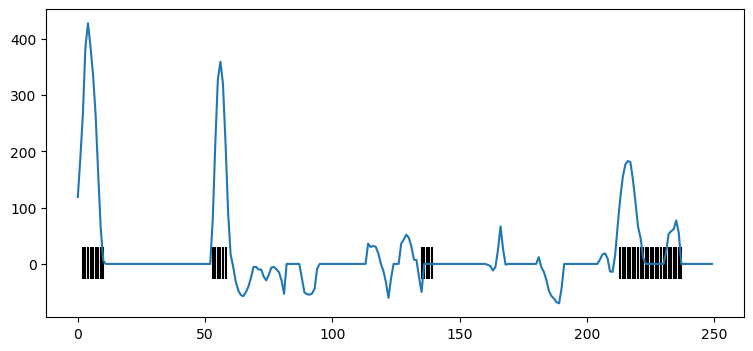

In [28]:
real_trigger = np.zeros(22800)
for i in range(22800):
    if dataset.loc[i,'PRECT'] > 0.5:
        real_trigger[i] = 1
    else:
        real_trigger[i] = np.nan

print(sum(real_trigger))
fig, ax = plt.subplots(1,1,figsize=(9,4))
ax.scatter(range(250),real_trigger[:250],color='k', marker='|',s=500)
ax.plot(range(250), dataset.loc[:250-1,'ddcape'])


## Performance with xgboost

### cross validation

In [171]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7,scale_pos_weight=3.5)
f1_scores = cross_val_score(xgb, trig_x, trig_y, cv=cv, scoring="f1_macro")
print(f1_scores)

[0.91  0.925 0.912 0.936 0.916]


### confusion report

In [29]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=-1, max_depth=7,scale_pos_weight=3.5)

print(trig_y_test.shape)
print(sum(trig_y_test))
print(trig_y_train.shape)
print(sum(trig_y_train))

xgb.fit(trig_x_train,trig_y_train)
trig_y_pred = xgb.predict(trig_x_test)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
p  = precision_score(trig_y_test, trig_y_pred,average='macro')
r  = recall_score(trig_y_test, trig_y_pred,average='macro')
print(tp,fp,fn,tn)
print(f1,p,r)

(4560,)
422.0
(18240,)
1569.0
348 46 74 4092
0.9192451547092826 0.9327429444548692 0.9067640341855281


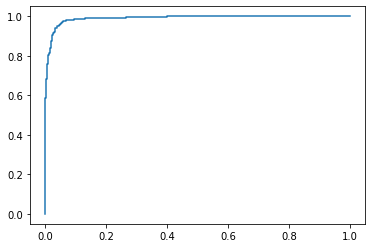

In [60]:
trig_y_pred_score = xgb.predict_proba(trig_x_test)[:,1]
fpr, tpr, _ = roc_curve(trig_y_test, trig_y_pred_score)
plt.plot(fpr,tpr)


In [32]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)
cape_trigger = np.zeros(trig_y_test.shape)

#print(trig_x_test)

for i in range(len(trig_y_test)):
    if trig_x_test.iloc[i,4] > 65:
        cape_trigger[i] = 1

tn, fp, fn, tp = confusion_matrix(trig_y_test, cape_trigger).ravel()
f1 = f1_score(trig_y_test, cape_trigger,average='macro')
p  = precision_score(trig_y_test, cape_trigger,average='macro')
r  = recall_score(trig_y_test, cape_trigger,average='macro')

print(tp,fp,fn,tn)
print(f1,p,r)

298 543 124 3595
0.6934999336416352 0.6604988875137123 0.7874691622438204


### 20% Testing

|          | TP  | FP  | FN  | TN  |  F1  |  P   | R    |
|----------|-----|-----|-----|-----|------|------|------|
|XGboost   | 339 |48   | 83  | 4090|0.911 |0.928 | 0.896|
|dd(0)     | 286 |502  | 136 | 3636|0.696 |0.663 |0.778 |
|dd(65)    | 207 |89   | 215 | 4049|0.770 |0.824 |0.735 |
|dc        | 155 |580  | 267 | 3558|0.580 |0.571 |0.613 |
|udd(0)    | 227 |856  | 195 | 3282|0.582 |0.577 |0.666 |
|udd(65)   | 178 |224  | 244 | 3914|0.688 |0.692 |0.684 |
|udc       | 170 |1966 | 252 | 2172|0.397 |0.488 |0.464 |

### importance

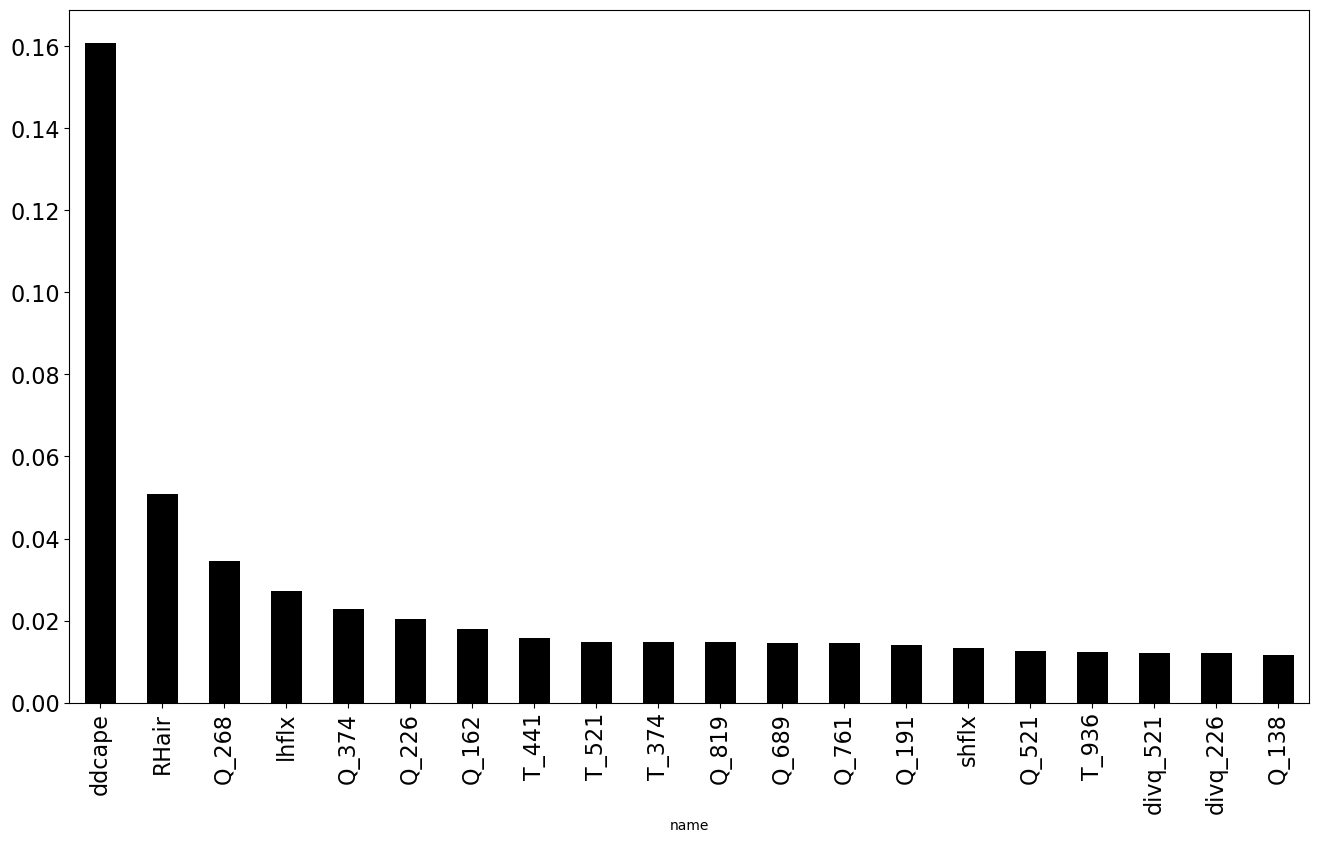

In [34]:
importance = xgb.feature_importances_
name = dataset.columns.values.tolist()
imp_df = pd.DataFrame(importance,columns=['imp'])
imp_df['name'] = name[0:86]
imp_df.set_index('name',inplace=True)
imp_df.sort_values('imp',inplace=True,ascending=False)
#print(imp_df)
imp_df.iloc[:20].plot.bar(figsize=(16,9), color='k',fontsize=16, legend=False)
plt.savefig("figs/sgp_imp.pdf")

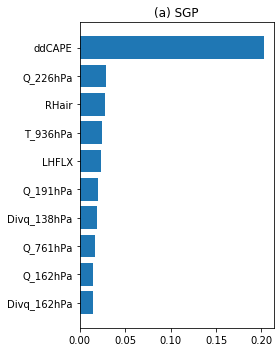

In [8]:
imp_data = imp_df.iloc[:10].values.reshape(-1)
var_name = ['ddCAPE','Q_226hPa','RHair','T_936hPa','LHFLX','Q_191hPa','Divq_138hPa', 'Q_761hPa','Q_162hPa','Divq_162hPa']
pos = np.arange(len(var_name))

fig, ax = plt.subplots(figsize=(4,5))
ax.invert_yaxis()
ax.barh(var_name,imp_data, color="tab:blue")
ax.set_title("(a) SGP")
plt.tight_layout()
plt.savefig("figs/sgp_imp.pdf")

<Figure size 1152x648 with 0 Axes>

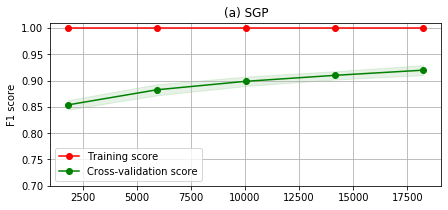

In [11]:
plt.figure(figsize=(16,9))
title = "(a) SGP"
plot_learning_curve.plot_learning_curve(xgb,title,trig_x, trig_y,ylim=(0.7, 1.01), cv=cv, n_jobs=8)
plt.xlabel("")
plt.savefig("figs/sgp_robust_sample.pdf")

In [21]:
plt.savefig("figs/robust_sample.png")
plt.savefig("figs/robust_sample.png")

<Figure size 432x288 with 0 Axes>

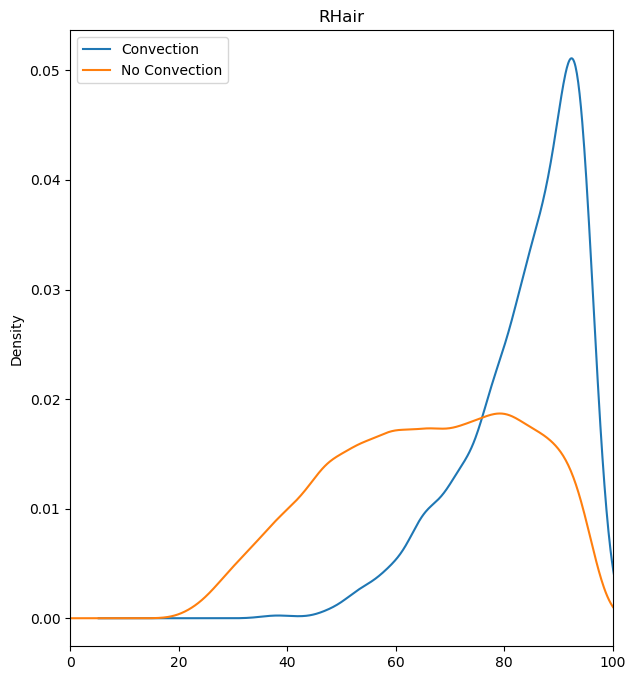

In [124]:
pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]

def single_factor_diag(pos, neg, name, figname):
   fac_pos = pos[name]
   fac_neg = neg[name]
   box_data = pd.concat([fac_pos, fac_neg], axis=1)
   box_data.columns = ['Convection', 'No Convection']
   #box_data.boxplot(grid=False)
   box_data.plot.kde(figsize=(7,8))
   plt.title(name)
   plt.xlim(0,100)
   plt.savefig(figname)

single_factor_diag(pos, neg, 'RHair', 'figs/RHair_hist.pdf')

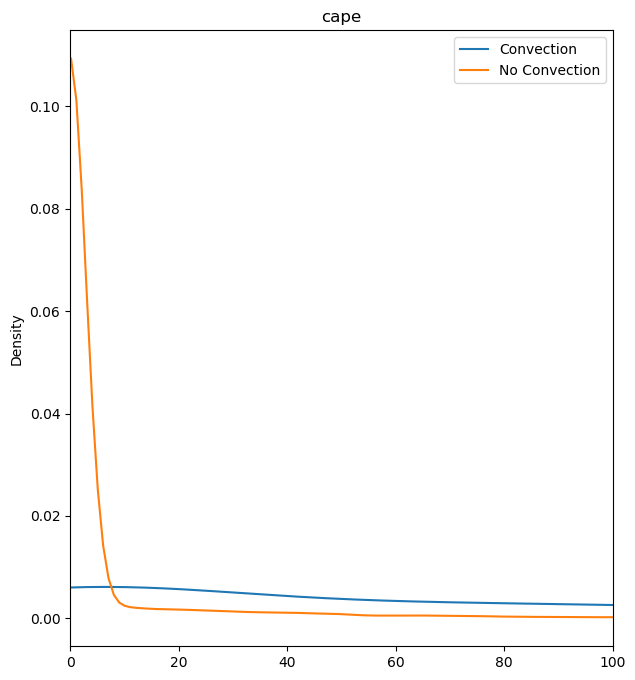

In [125]:
single_factor_diag(pos, neg, 'cape', 'figs/cape_hist.pdf')

Q_117    float64
Q_138    float64
Q_162    float64
Q_191    float64
Q_226    float64
Q_268    float64
Q_316    float64
Q_374    float64
Q_441    float64
Q_521    float64
Q_607    float64
Q_689    float64
Q_761    float64
Q_819    float64
Q_858    float64
Q_886    float64
Q_912    float64
Q_936    float64
Q_957    float64
Q_976    float64
dtype: object
[484. 570. 543. 394.]
[5333. 5065. 2320. 8091.]


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


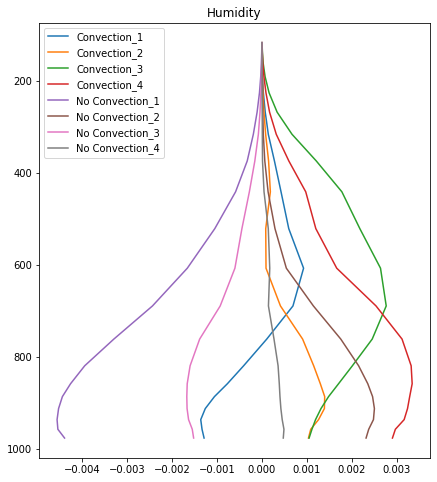

In [114]:
from sklearn.cluster import KMeans
def profile_anom_clustering(trig_df):
    
    
    start = 26
    end   = 46
    df_mean = trig_df.mean().iloc[start:end]
    print(trig_df.iloc[:,start:end].dtypes)

    trig_pos_df = trig_df[trig_df.label == 1]
    trig_neg_df = trig_df[trig_df.label == 0]

    kmeans_pos = KMeans(n_clusters=4, random_state=0, n_jobs=8).fit(trig_pos_df.iloc[:,start:end])
    kmeans_neg = KMeans(n_clusters=4, random_state=0, n_jobs=8).fit(trig_neg_df.iloc[:,start:end])
    label_pos  = kmeans_pos.labels_
    label_neg  = kmeans_neg.labels_
    
    freq_pos = np.zeros(4)
    for i in label_pos:
        freq_pos[i] += 1
    
    print(freq_pos)
    
    freq_neg = np.zeros(4)
    for i in label_neg:
        freq_neg[i] += 1
    
    print(freq_neg)

    trig_pos_df['kmeans'] = label_pos
    trig_neg_df['kmeans'] = label_neg

    trig_pos_anom_1 = np.mean(trig_pos_df[trig_pos_df.kmeans == 0].iloc[:,start:end] - df_mean)
    trig_pos_anom_2 = np.mean(trig_pos_df[trig_pos_df.kmeans == 9].iloc[:,start:end] - df_mean)
    trig_pos_anom_3 = np.mean(trig_pos_df[trig_pos_df.kmeans == 6].iloc[:,start:end] - df_mean)
    trig_pos_anom_4 = np.mean(trig_pos_df[trig_pos_df.kmeans == 5].iloc[:,start:end] - df_mean)
    
    trig_pos_anom_1 = np.mean(trig_pos_df[trig_pos_df.kmeans == 0].iloc[:,start:end] - df_mean)
    trig_pos_anom_2 = np.mean(trig_pos_df[trig_pos_df.kmeans == 1].iloc[:,start:end] - df_mean)
    trig_pos_anom_3 = np.mean(trig_pos_df[trig_pos_df.kmeans == 2].iloc[:,start:end] - df_mean)
    trig_pos_anom_4 = np.mean(trig_pos_df[trig_pos_df.kmeans == 3].iloc[:,start:end] - df_mean)

    trig_neg_anom_1 = np.mean(trig_neg_df[trig_neg_df.kmeans == 10].iloc[:,start:end] - df_mean)
    trig_neg_anom_2 = np.mean(trig_neg_df[trig_neg_df.kmeans == 0].iloc[:,start:end] - df_mean)
    trig_neg_anom_3 = np.mean(trig_neg_df[trig_neg_df.kmeans == 8].iloc[:,start:end] - df_mean)
    trig_neg_anom_4 = np.mean(trig_neg_df[trig_neg_df.kmeans == 6].iloc[:,start:end] - df_mean)
    
    trig_neg_anom_1 = np.mean(trig_neg_df[trig_neg_df.kmeans == 2].iloc[:,start:end] - df_mean)
    trig_neg_anom_2 = np.mean(trig_neg_df[trig_neg_df.kmeans == 0].iloc[:,start:end] - df_mean)
    trig_neg_anom_3 = np.mean(trig_neg_df[trig_neg_df.kmeans == 1].iloc[:,start:end] - df_mean)
    trig_neg_anom_4 = np.mean(trig_neg_df[trig_neg_df.kmeans == 3].iloc[:,start:end] - df_mean)

    #trig_pos_anom_1 = np.mean(trig_pos_df[trig_pos_df.kmeans == 0].iloc[:,start:end])
    #trig_pos_anom_2 = np.mean(trig_pos_df[trig_pos_df.kmeans == 9].iloc[:,start:end])
    #trig_pos_anom_3 = np.mean(trig_pos_df[trig_pos_df.kmeans == 6].iloc[:,start:end])
    #trig_pos_anom_4 = np.mean(trig_pos_df[trig_pos_df.kmeans == 5].iloc[:,start:end])

    #trig_neg_anom_1 = np.mean(trig_neg_df[trig_neg_df.kmeans == 2].iloc[:,start:end])
    #trig_neg_anom_2 = np.mean(trig_neg_df[trig_neg_df.kmeans == 0].iloc[:,start:end])
    #trig_neg_anom_3 = np.mean(trig_neg_df[trig_neg_df.kmeans == 1].iloc[:,start:end])
    #trig_neg_anom_4 = np.mean(trig_neg_df[trig_neg_df.kmeans == 6].iloc[:,start:end])   

    lev = [117,138,162,191,226,268,316,374,441,521,607,689,761,819,858,886,912,936,957,976]

    plt.figure(figsize=(7,8))
    plt.plot(trig_pos_anom_1, lev, label="Convection_1")
    plt.plot(trig_pos_anom_2, lev, label="Convection_2")
    plt.plot(trig_pos_anom_3, lev, label="Convection_3")
    plt.plot(trig_pos_anom_4, lev, label="Convection_4")

    plt.plot(trig_neg_anom_1, lev, label="No Convection_1")
    plt.plot(trig_neg_anom_2, lev, label="No Convection_2")
    plt.plot(trig_neg_anom_3, lev, label="No Convection_3")
    plt.plot(trig_neg_anom_4, lev, label="No Convection_4")
    plt.legend()
    plt.title("Humidity")
    plt.gca().invert_yaxis()

    
profile_anom_clustering(dataset)

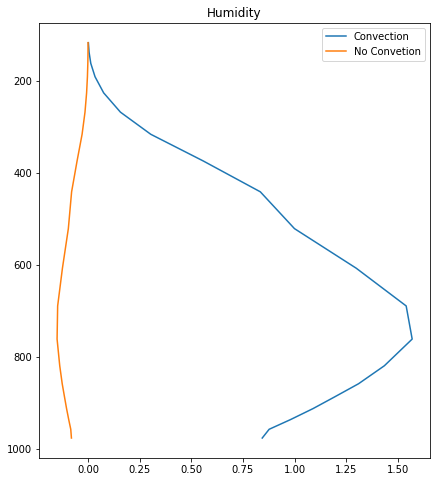

In [115]:
def profile_anom_confusion(trig_df):
    trig_df_mean = trig_df.mean()
    T_mean = trig_df_mean[6:26]
    Q_mean = trig_df_mean[26:46]
    divs_mean = trig_df_mean[46:66]
    divq_mean = trig_df_mean[66:86]

    trig_pos_df = trig_df[trig_df.label == 1]
    trig_neg_df = trig_df[trig_df.label == 0]

    T_pos_anom = trig_pos_df.iloc[:,6:26] - T_mean
    T_neg_anom = trig_neg_df.iloc[:,6:26] - T_mean
    Q_pos_anom = trig_pos_df.iloc[:,26:46] - Q_mean
    Q_neg_anom = trig_neg_df.iloc[:,26:46] - Q_mean
    divs_pos_anom = trig_pos_df.iloc[:,46:66] - divs_mean
    divs_neg_anom = trig_neg_df.iloc[:,46:66] - divs_mean
    divq_pos_anom = trig_pos_df.iloc[:,66:86] - divq_mean
    divq_neg_anom = trig_neg_df.iloc[:,66:86] - divq_mean

    T_pos_anom_mean = np.mean(T_pos_anom, axis=0)
    T_neg_anom_mean = np.mean(T_neg_anom, axis=0)
    Q_pos_anom_mean = np.mean(Q_pos_anom, axis=0) * 1000.0
    Q_neg_anom_mean = np.mean(Q_neg_anom, axis=0) * 1000.0
    divs_pos_anom_mean = np.mean(divs_pos_anom, axis=0)
    divs_neg_anom_mean = np.mean(divs_neg_anom, axis=0)
    divq_pos_anom_mean = np.mean(divq_pos_anom, axis=0)
    divq_neg_anom_mean = np.mean(divq_neg_anom, axis=0)

    T_pos_anom_std = np.std(T_pos_anom, axis=0)
    T_neg_anom_std = np.std(T_neg_anom, axis=0)
    Q_pos_anom_std = np.std(Q_pos_anom, axis=0)
    Q_neg_anom_std = np.std(Q_neg_anom, axis=0)

    lev = [117,138,162,191,226,268,316,374,441,521,607,689,761,819,858,886,912,936,957,976]
    
    plt.figure(figsize=(7,8))
    #plt.subplot(221)
    #plt.plot(T_pos_anom_mean, lev, label="Convection")
    #plt.plot(T_neg_anom_mean, lev, label="No Convection")
    #plt.legend()
    #plt.title("Temperature")
    #plt.gca().invert_yaxis()

    #plt.subplot(222)
    #plt.plot(Q_pos_anom_mean, lev, label="Convection")
    plt.plot(Q_pos_anom_mean, lev, label="Convection")
    plt.plot(Q_neg_anom_mean, lev, label="No Convetion")
    plt.legend()
    plt.title("Humidity")
    plt.gca().invert_yaxis()

    #plt.subplot(223)
    #plt.plot(divs_pos_anom_mean, lev, label="Convection")
    #plt.plot(divs_neg_anom_mean, lev, label="No Convection")
    #plt.legend()
    #plt.title("DIVS")
    #plt.gca().invert_yaxis()

    #plt.subplot(224)
    #plt.plot(divq_pos_anom_mean, lev, label="Convection")
    #plt.plot(divq_neg_anom_mean, lev, label="No Convection")
    #plt.legend()
    #plt.title("DIVQ")
    #plt.gca().invert_yaxis()
    plt.savefig("figs/humidity_2cla.pdf")
    
profile_anom_confusion(dataset)

In [116]:
pred_size = trig_y_pred.shape
trig_x_test['CT'] = np.zeros(pred_size)
print(trig_x_test.dtypes)

for i in range(pred_size[0]):
    if(trig_y_test.iloc[i] == 1 and trig_y_pred[i] == 1):
        trig_x_test.iloc[i,86] = 0 
    if(trig_y_test.iloc[i] == 0 and trig_y_pred[i] == 1):
        trig_x_test.iloc[i,86] = 1
    if(trig_y_test.iloc[i] == 1 and trig_y_pred[i] == 0):
        trig_x_test.iloc[i,86] = 2
    if(trig_y_test.iloc[i] == 0 and trig_y_pred[i] == 0):
        trig_x_test.iloc[i,86] = 3


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/p

lhflx       float64
shflx       float64
Tsair       float64
RHair       float64
cape        float64
lcl         float64
T_117       float64
T_138       float64
T_162       float64
T_191       float64
T_226       float64
T_268       float64
T_316       float64
T_374       float64
T_441       float64
T_521       float64
T_607       float64
T_689       float64
T_761       float64
T_819       float64
T_858       float64
T_886       float64
T_912       float64
T_936       float64
T_957       float64
T_976       float64
Q_117       float64
Q_138       float64
Q_162       float64
Q_191       float64
             ...   
divs_689    float64
divs_761    float64
divs_819    float64
divs_858    float64
divs_886    float64
divs_912    float64
divs_936    float64
divs_957    float64
divs_976    float64
divq_117    float64
divq_138    float64
divq_162    float64
divq_191    float64
divq_226    float64
divq_268    float64
divq_316    float64
divq_374    float64
divq_441    float64
divq_521    float64


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This 

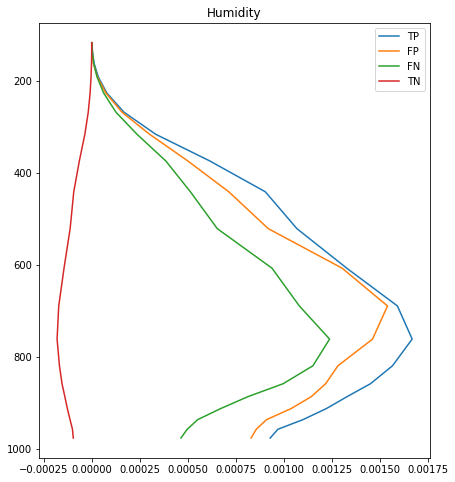

In [117]:
TP = trig_x_test[trig_x_test.CT==0]
FP = trig_x_test[trig_x_test.CT==1]
FN = trig_x_test[trig_x_test.CT==2]
TN = trig_x_test[trig_x_test.CT==3]

def confusion_diag(TP_df, FP_df, FN_df, TN_df, trig_xx_test):
    start = 26
    end   = 46

    df_mean = np.mean(trig_xx_test, axis=0)[start:end]

    TP_anom = TP_df.iloc[:,start:end] - df_mean
    FP_anom = FP_df.iloc[:,start:end] - df_mean
    FN_anom = FN_df.iloc[:,start:end] - df_mean
    TN_anom = TN_df.iloc[:,start:end] - df_mean

    TP_anom_mean = np.mean(TP_anom, axis=0)
    FP_anom_mean = np.mean(FP_anom, axis=0)
    FN_anom_mean = np.mean(FN_anom, axis=0)
    TN_anom_mean = np.mean(TN_anom, axis=0)

    lev = [117,138,162,191,226,268,316,374,441,521,607,689,761,819,858,886,912,936,957,976]

    plt.figure(figsize=(7,8))
    plt.plot(TP_anom_mean, lev, label="TP")
    plt.plot(FP_anom_mean, lev, label="FP")
    plt.plot(FN_anom_mean, lev, label="FN")
    plt.plot(TN_anom_mean, lev, label="TN")
    plt.legend()
    plt.title("Humidity")
    plt.gca().invert_yaxis()
    plt.savefig("figs/humudity_ct.pdf")

confusion_diag(TP, FP, FN, TN, trig_x_test)

In [35]:
sl = trig_x.shape[0]
train_len = int(sl * 1 / 4)
ts_x_test = trig_x.iloc[:train_len,:]
ts_y_test = trig_y.iloc[:train_len]
ts_x_train  = trig_x.iloc[train_len:,:]
ts_y_train  = trig_y.iloc[train_len:].values.tolist()
prect_test = dataset['PRECT'].iloc[:train_len]
hour_test  = dataset['hour'].iloc[:train_len]
day_test  = dataset['day'].iloc[:train_len]
mon_test  = dataset['mon'].iloc[:train_len]
year_test = dataset['year'].iloc[:train_len]

#print(year_test)
#print(mon_test)
#print(day_test)
#print(hour_test)

xgb.fit(ts_x_train, ts_y_train)
ts_y_pred = xgb.predict(ts_x_test)

for i in range(ts_x_test.shape[0]):
    if ts_y_pred[i] == 0:
        ts_y_pred[i] = np.nan
    if ts_y_test[i] == 0:
        ts_y_test[i] = np.nan

In [22]:
#dilute_cape = np.loadtxt("../../data/sgp/dilute_cape")
#dilute_dcape = np.loadtxt("../../data/sgp/dilute_dcape")
#undilute_dcape = np.loadtxt("../../data/sgp/undilute_dcape")
#undilute_cape = np.loadtxt("../../data/sgp/undilute_cape")

dilute_cape_test = dilute_cape[train_len:]
dilute_dcape_test = dilute_dcape[train_len:]
undilute_dcape_test = undilute_dcape[train_len:]
undilute_cape_test = undilute_cape[train_len:]

dilute_cape_pred = np.zeros(ts_y_pred.shape)
dilute_dcape_pred = np.zeros(ts_y_pred.shape)
undilute_dcape_pred = np.zeros(ts_y_pred.shape)
undilute_cape_pred = np.zeros(ts_y_pred.shape)


for i in range(len(ts_y_pred)):
    if dilute_cape_test[i] > 70:
        dilute_cape_pred[i] = 1
    else:
        dilute_cape_pred[i] = np.nan
        
    if dilute_dcape_test[i] > 65:
        dilute_dcape_pred[i] = 1
    else:
        dilute_dcape_pred[i] = np.nan
        
    if undilute_dcape_test[i] > 65:
        undilute_dcape_pred[i] = 1
    else:
        undilute_dcape_pred[i] = np.nan
        
    if undilute_cape_test[i] > 70:
        undilute_cape_pred[i] = 1
    else:
        undilute_cape_pred[i] = np.nan

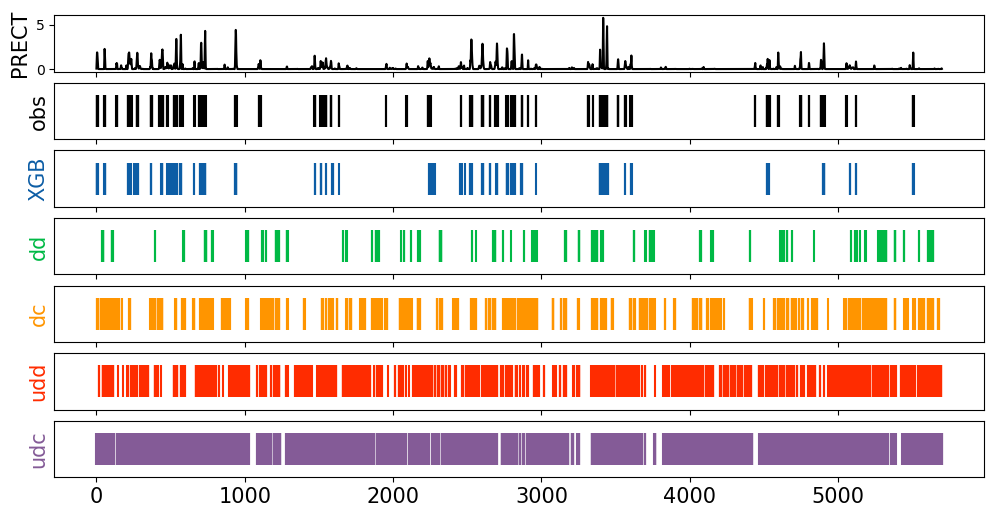

In [23]:
fh=15
plt.style.use('default')
colors=['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
fig, axes = plt.subplots(nrows=7, ncols=1, sharex=True, figsize=(12,6))
trig_idx = range(len(ts_y_pred))


axes[0].plot(prect_test.values.tolist(), color='k')
axes[0].set_ylabel('PRECT',fontsize=fh)
axes[1].scatter(trig_idx,ts_y_test,color='k', marker='|',s=500)
axes[1].set_ylabel('obs',fontsize=fh)
axes[1].set_yticks([])
axes[2].scatter(trig_idx,ts_y_pred,color=colors[0], marker='|',s=500)
axes[2].set_ylabel('XGB',color=colors[0],fontsize=fh)
axes[2].set_yticks([])
axes[3].scatter(trig_idx,dilute_dcape_pred,color=colors[1], marker='|',s=500)
axes[3].set_ylabel('dd',color=colors[1],fontsize=fh)
axes[3].set_yticks([])
axes[4].scatter(trig_idx,dilute_cape_pred, color=colors[2], marker='|',s=500)
axes[4].set_ylabel('dc',color=colors[2],fontsize=fh)
axes[4].set_yticks([])
axes[5].scatter(trig_idx,undilute_dcape_pred,color=colors[3], marker='|',s=500)
axes[5].set_ylabel('udd',color=colors[3],fontsize=fh)
axes[5].set_yticks([])
axes[6].scatter(trig_idx,undilute_cape_pred,color=colors[4], marker='|',s=500)
axes[6].set_ylabel('udc',color=colors[4],fontsize=fh)
axes[6].set_yticks([])


    
plt.tick_params(labelsize=fh)

plt.savefig("figs/sgp_ts.pdf")

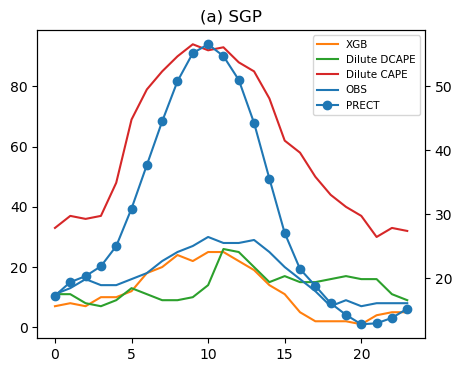

In [24]:
diurnal_prect = np.zeros(24)
diurnal_obs  = np.zeros(24)
diurnal_xgboost  = np.zeros(24)
diurnal_dd  = np.zeros(24)
diurnal_dc  = np.zeros(24)
diurnal_udd  = np.zeros(24)
diurnal_udc  = np.zeros(24)
diurnal_obs  = np.zeros(24)

prect_df = pd.concat([prect_test, hour_test], axis=1)
xgboost_df  = pd.DataFrame({"pred":ts_y_pred, "hour":hour_test})
dd_df = pd.DataFrame({"pred":dilute_dcape_pred, "hour":hour_test})
dc_df = pd.DataFrame({"pred":dilute_cape_pred, "hour":hour_test})
udd_df = pd.DataFrame({"pred":undilute_dcape_pred, "hour":hour_test})
udc_df = pd.DataFrame({"pred":undilute_cape_pred, "hour":hour_test})
obs_df = pd.DataFrame({"pred":ts_y_test, "hour":hour_test})

for i in range(24):
    diurnal_prect[i] = prect_df[prect_df.hour == i].sum().PRECT
    diurnal_xgboost[i]  = xgboost_df[xgboost_df.hour == i].sum().pred
    diurnal_dd[i]  = dd_df[dd_df.hour == i].sum().pred
    diurnal_dc[i]  = dc_df[dc_df.hour == i].sum().pred
    diurnal_udd[i]  = udd_df[udd_df.hour == i].sum().pred
    diurnal_udc[i]  = udc_df[udc_df.hour == i].sum().pred
    diurnal_obs[i]  = obs_df[obs_df.hour == i].sum().pred

dilurnal_df = pd.DataFrame({"obs":diurnal_obs,"xgboost":diurnal_xgboost, "dilute_dcape":diurnal_dd,"dilute_cape":diurnal_dc
                           })#"undilute_dcape":diurnal_udd, "undilute_cape":diurnal_udc})
#ax1 = dilurnal_df.plot(figsize=(9,3))

#ax2 = ax1.twinx()

#ax2.plot(range(24), diurnal_prect, 'ro-', label="PRECT")
#plt.bar(range(24), diurnal_xgboost, label="XGBoost")
#plt.bar(range(24), diurnal_dd, label="dd")
#ax2.legend(loc = 'upper right',fontsize=8)
#plt.legend(loc = 'upper center',fontsize=8)
#plt.savefig("figs/sgp_dilurnal.pdf")

fig, ax1 = plt.subplots(figsize=(5,4))
ax2 = ax1.twinx()
ax1.plot(diurnal_xgboost, color="tab:orange", label="XGB")
ax1.plot(diurnal_dd, color="tab:green", label="Dilute DCAPE")
ax1.plot(diurnal_dc, color="tab:red", label="Dilute CAPE")
ax1.plot(diurnal_obs, color="tab:blue", label="OBS")

ax2.plot(diurnal_prect,'o-', color="tab:blue")
ax1.plot(np.nan, 'o-', color="tab:blue", label='PRECT')
plt.title("(a) SGP")

ax1.legend(fontsize=7.5)
plt.savefig("figs/sgp_dilurnal.pdf")

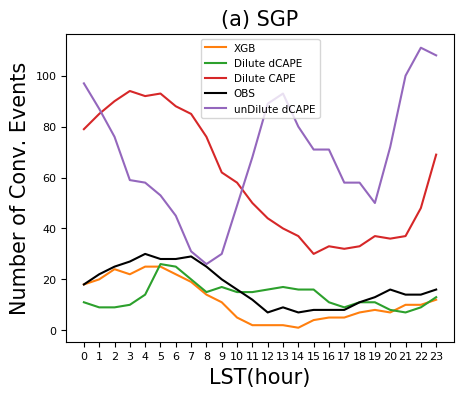

In [26]:


lst_time = np.arange(24) - 6
lst_time[lst_time < 0] += 24

diurnal_xgboost_lst  = np.zeros(24)
diurnal_dd_lst = np.zeros(24)
diurnal_udd_lst = np.zeros(24)
diurnal_dc_lst = np.zeros(24)
diurnal_obs_lst = np.zeros(24)

for i in range(24):
    diurnal_xgboost_lst[lst_time[i]] = diurnal_xgboost[i]
    diurnal_dd_lst[lst_time[i]] = diurnal_dd[i]
    diurnal_udd_lst[lst_time[i]] = diurnal_udd[i]
    diurnal_dc_lst[lst_time[i]] = diurnal_dc[i]
    diurnal_obs_lst[lst_time[i]] = diurnal_obs[i]
    

fig, ax1 = plt.subplots(figsize=(5,4))
#ax2 = ax1.twinx()
ax1.plot(diurnal_xgboost_lst, color="tab:orange", label="XGB")
ax1.plot(diurnal_dd_lst, color="tab:green", label="Dilute dCAPE")
ax1.plot(diurnal_dc_lst, color="tab:red", label="Dilute CAPE")
ax1.plot(diurnal_obs_lst, color="black", label="OBS")
ax1.plot(diurnal_udd_lst,color='tab:purple', label="unDilute dCAPE")


ax1.xaxis.set_ticks(np.arange(0,24,1))
ax1.tick_params(axis="x", labelsize=8)
ax1.tick_params(axis="y", labelsize=8)

ax1.legend(fontsize=7.5)
plt.title("(a) SGP",fontsize=fh)
plt.xlabel("LST(hour)", fontsize=fh)
plt.ylabel("Number of Conv. Events",fontsize=fh)
plt.savefig("figs/sgp_dilurnal.pdf")

## decision tree

In [31]:
from sklearn import tree
trig_x=dataset[['ddcape','RHair','T_976']]
#trig_x=dataset[['cape']]
print(trig_x.shape)

trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
dt = tree.DecisionTreeClassifier(max_depth=3)

dt.fit(trig_x_train,trig_y_train)
trig_y_pred = dt.predict(trig_x_test)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
p  = precision_score(trig_y_test, trig_y_pred,average='macro')
r  = recall_score(trig_y_test, trig_y_pred,average='macro')
print(tp,fp,fn,tn)
print(f1,p,r)

(22800, 3)
213 45 209 4093
0.7981879007527182 0.8884996702453158 0.7469322588699352


In [42]:
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=3,scale_pos_weight=3.5)
xgb.fit(trig_x_train,trig_y_train)
trig_y_pred = xgb.predict(trig_x_test)
tn, fp, fn, tp = confusion_matrix(trig_y_test, trig_y_pred).ravel()
f1 = f1_score(trig_y_test, trig_y_pred,average='macro')
p  = precision_score(trig_y_test, trig_y_pred,average='macro')
r  = recall_score(trig_y_test, trig_y_pred,average='macro')
print(xgb)
print(tp,fp,fn,tn)
print(f1,p,r)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=8, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.5, seed=None,
              silent=True, subsample=1, verbosity=1)
354 69 68 4069
0.9106569656232681 0.9102212004793278 0.9110939185768705


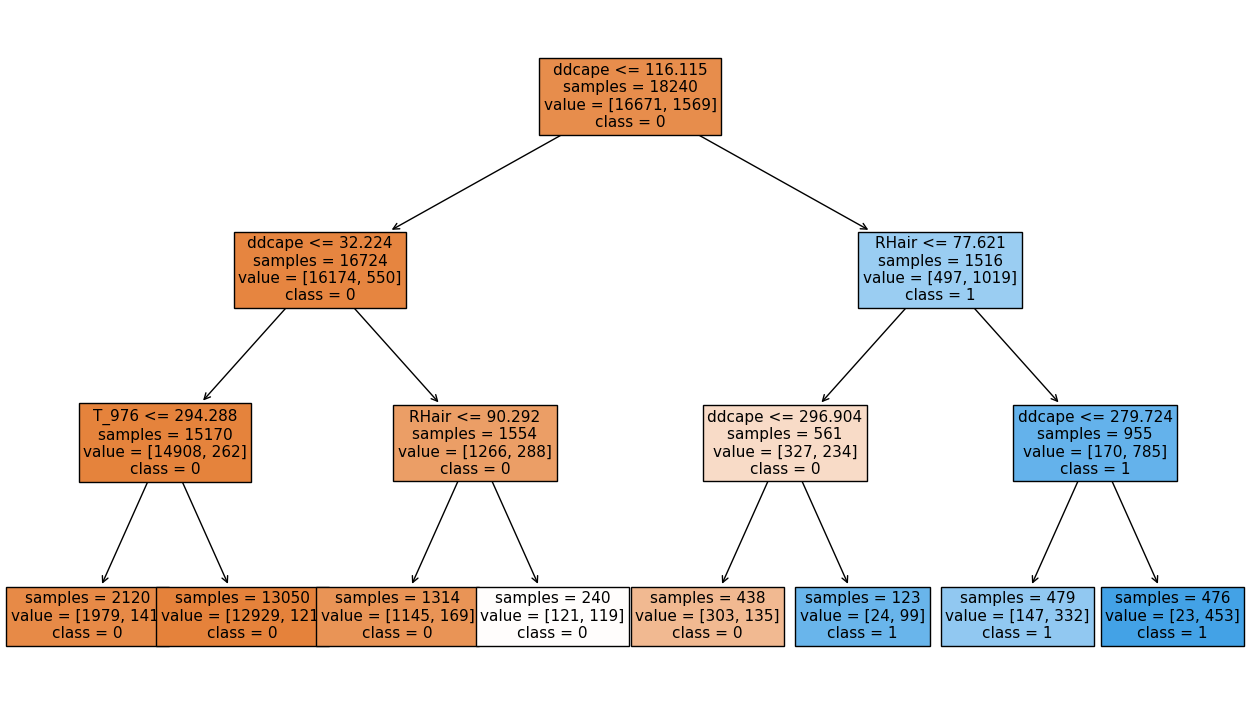

In [32]:
plt.figure(figsize=(16,9))
tree.plot_tree(dt.fit(trig_x_train,trig_y_train), proportion=False, impurity=False,filled=True, feature_names=trig_x.columns, label='all', fontsize=11, class_names=['0','1'])
plt.savefig("figs/SGP_dt.pdf")

In [51]:
print(trig_x_train.dtypes)

lhflx       float64
shflx       float64
Tsair       float64
RHair       float64
ddcape      float64
             ...   
divq_886    float64
divq_912    float64
divq_936    float64
divq_957    float64
divq_976    float64
Length: 86, dtype: object


1382
241 200 63 2674
0.8000538252402101 0.7617336789788379 0.8615868677434715


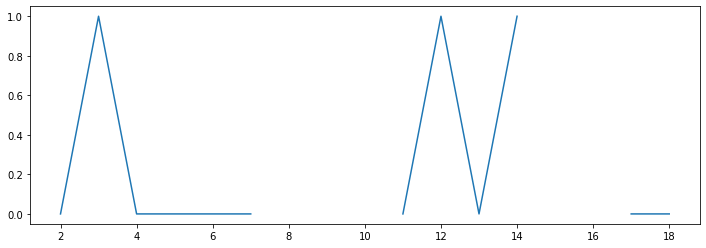

In [8]:
plt.figure(figsize=(12,4))

trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)
cape_trigger = np.zeros(trig_y_test.shape)

#print(trig_x_test)
j = 0
for i in range(len(trig_y_test)):
    if trig_x_test.iloc[i,4] > 116 and trig_x_test.iloc[i,3] > 78:
        cape_trigger[i] = 1
    elif trig_x_test.iloc[i,4] < 32 and trig_x_test.iloc[i,trig_x_test.columns.get_loc('T_976')] > 294:
        cape_trigger[i] = 0
    else:
        cape_trigger[i] = np.nan
        j = j + 1
        
print(j)

plt.plot(cape_trigger[:20])

perf = pd.DataFrame({"real":trig_y_test, "pred":cape_trigger})
perf = perf.dropna()




tn, fp, fn, tp = confusion_matrix(perf.loc[:,"real"], perf.loc[:,"pred"]).ravel()
f1 = f1_score(perf.loc[:,"real"], perf.loc[:,"pred"],average='macro')
p  = precision_score(perf.loc[:,"real"], perf.loc[:,"pred"],average='macro')
r  = recall_score(perf.loc[:,"real"], perf.loc[:,"pred"],average='macro')

print(tp,fp,fn,tn)
print(f1,p,r)



In [44]:
trig_x_train.head()

,lhflx,shflx,Tsair,RHair,ddcape,lcl,T_117,T_138,T_162,T_191,...,divq_607,divq_689,divq_761,divq_819,divq_858,divq_886,divq_912,divq_936,divq_957,divq_976
14713,44.731285,-19.053572,302.387451,37.789238,0.0000,22.0,210.239868,213.668198,218.777847,225.568039,...,1.461851e-08,8.905765e-09,-7.866802e-10,9.317384e-09,2.380619e-08,2.455564e-08,2.382650e-08,1.989582e-08,9.122247e-09,8.262141e-09
13580,393.831787,148.165527,297.564941,40.277649,0.0000,25.0,212.306778,214.724960,218.135025,223.484512,...,1.011347e-08,1.115465e-08,-2.008234e-08,-3.234545e-09,1.221038e-08,2.766430e-08,3.605681e-08,2.288462e-08,6.264612e-10,-1.533867e-09
18585,-2.529510,-13.193373,298.398773,90.990524,0.0000,28.0,209.940094,213.609818,219.443970,226.858673,...,3.544769e-08,7.420710e-08,9.478482e-08,3.741177e-08,-2.576257e-08,-8.850782e-08,-1.127559e-07,-6.286312e-08,-2.520572e-09,2.401198e-08
8698,1.055230,-1.368870,297.661865,95.007347,0.0000,26.0,210.510025,214.423553,219.147705,224.827240,...,-2.834011e-08,1.075466e-08,1.481130e-08,4.466672e-09,1.098345e-08,5.550820e-09,-2.393982e-08,-4.978418e-08,-5.174610e-08,-5.183959e-08
15212,206.058426,66.097076,299.649048,68.413261,41.6437,26.0,209.596161,214.503174,220.588837,227.849625,...,-2.022645e-09,6.439790e-10,1.094006e-08,5.994742e-09,7.155910e-09,1.368546e-08,1.413170e-08,1.220912e-08,1.259156e-08,1.259156e-08


In [1]:
TN = 625
FN = 6
TP = 42
FP = 11

Precision_P = TP/(TP+FP)
Precision_N = TN/(TN+FN)
Recall_P = TP/(TP+FN)
Recall_N = TN/(TN+FP)
F1_P = 2 * Precision_P * Recall_P / (Precision_P + Recall_P)
F1_N = 2 * Precision_N * Recall_N / (Precision_N + Recall_N)

P  = (Precision_P + Precision_N) / 2
R  = (Recall_P + Recall_N) / 2
F1 = (F1_P+F1_N)/2
print(F1, P, R)

0.9091328233060085 0.8914720569326915 0.9288522012578616


## knowledge compare

In [7]:
cape_trigger = np.zeros(len(dilute_cape))

for i in range(len(undilute_cape)):
    if dilute_dcape[i] > 56:
        cape_trigger[i] = 1

tn, fp, fn, tp = confusion_matrix(trig_y, cape_trigger).ravel()
f1 = f1_score(trig_y, cape_trigger,average='macro')

print(tp,fp,fn,tn)
print(f1)

1021 500 970 20309
0.7732541298652265


## tmp

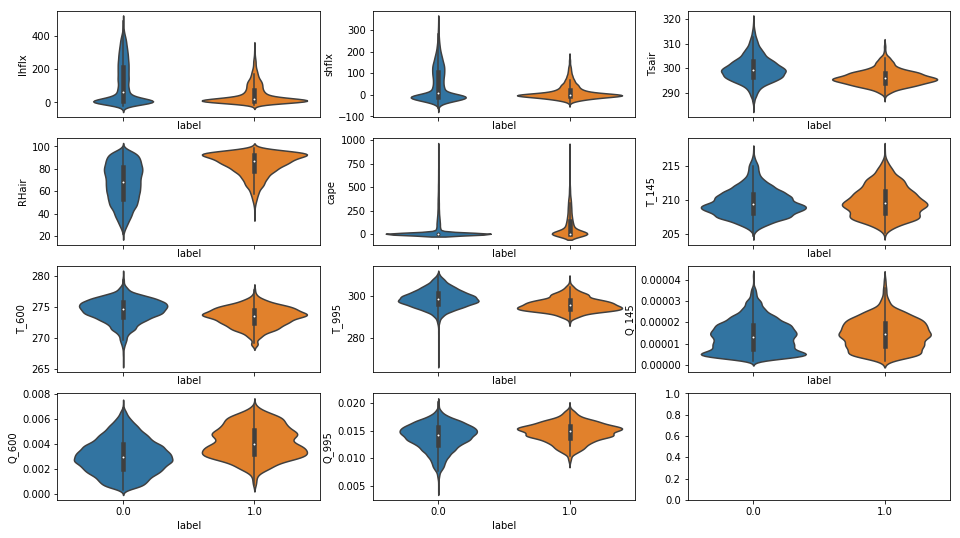

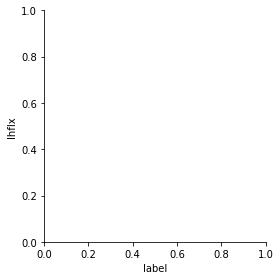

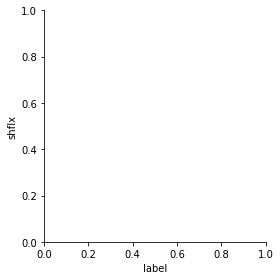

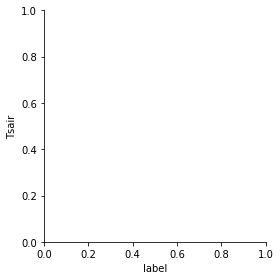

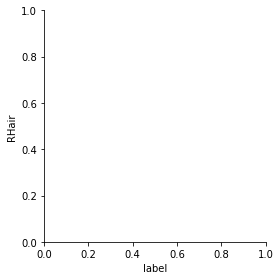

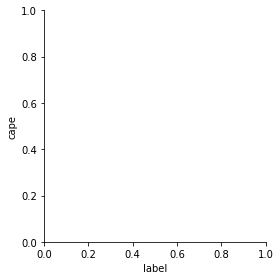

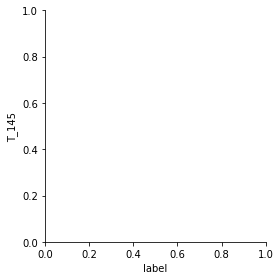

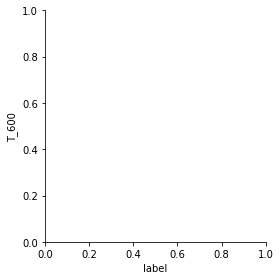

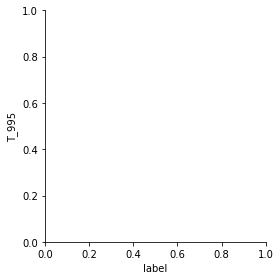

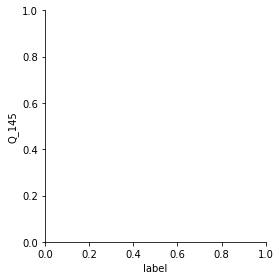

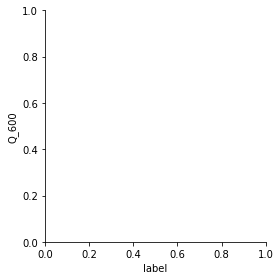

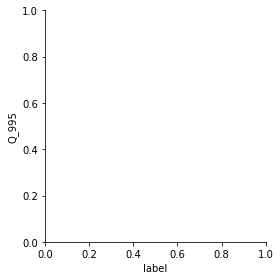

In [17]:
f, axes = plt.subplots(4, 3, figsize=(16, 9), sharex=True)
vars_name = ["lhflx","shflx","Tsair","RHair","cape","T_145","T_600","T_995", "Q_145","Q_600", "Q_995"]
for id in range(len(vars_name)):
    g = sns.factorplot(x="label", y = vars_name[id],data = dataset, kind="violin",ax=axes[id//3, id%3])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
No handles with labels found to put in legend.
/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/R1/zhangtao/soft/anac

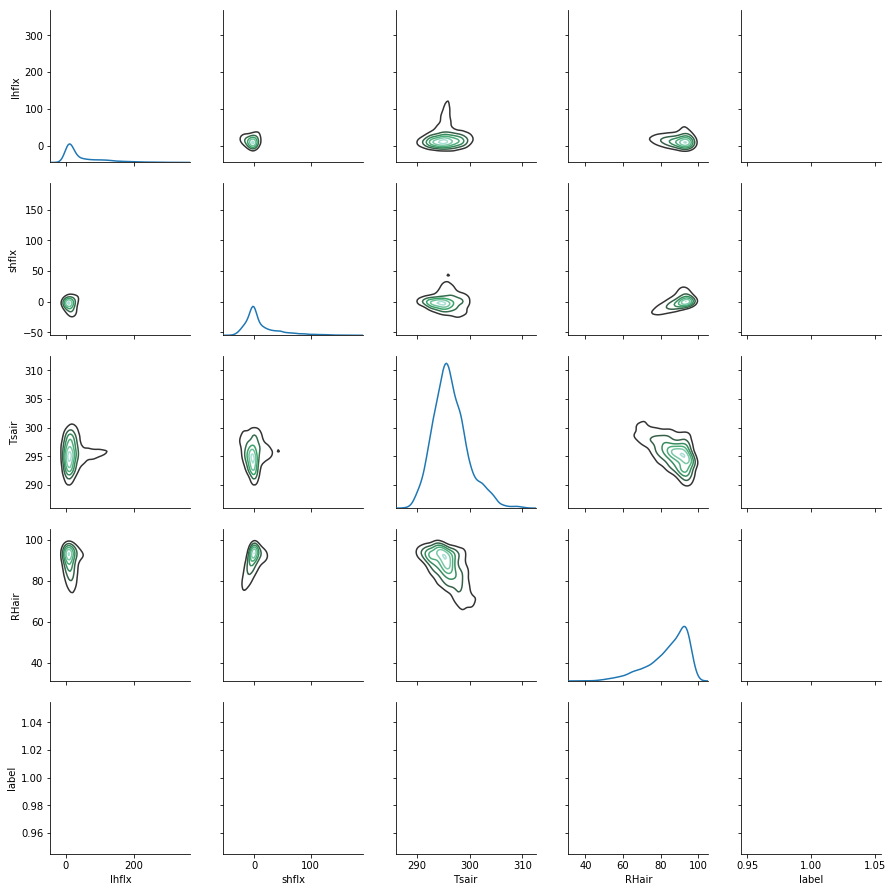

In [25]:
#dataset_sub = dataset.loc[:, ["lhflx","shflx","Tsair","RHair","cape","T_145","T_600","T_995", "Q_145","Q_600", "Q_995","label"]]
dataset_sub = dataset.loc[:, ["lhflx","shflx","Tsair","RHair","label"]]
pos = dataset_sub[dataset_sub.label==1]
neg = dataset_sub[dataset_sub.label==0]

g = sns.PairGrid(pos)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [9]:
dataset_sub = dataset.loc[:, ["lhflx","shflx","Tsair","RHair","label"]]
pos = dataset_sub[dataset_sub.label==1]
neg = dataset_sub[dataset_sub.label==0]
pos.drop('label', axis=1, inplace=True)
neg.drop('label', axis=1, inplace=True)
print(pos.shape)
print(neg.shape)

#g = sns.PairGrid(neg)
#g.map_diag(sns.kdeplot)

#g.map_lower(sns.kdeplot, n_levels=6);

(2283, 4)
(22725, 4)


/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
print("pos")
print(pos.shape)
H,edges = np.histogramdd(pos.values,bins = (20, 20, 10,10))

H[1,3,2,9] = 0
H[1,3,1,9] = 0
H_index = np.argwhere(H.max() == H)
print(H_index)
print(H.max())

print(edges[0][H_index[0][0]], edges[0][H_index[0][0]+1])
print(edges[1][H_index[0][1]], edges[1][H_index[0][1]+1])
print(edges[2][H_index[0][2]], edges[2][H_index[0][2]+1])
print(edges[3][H_index[0][3]], edges[3][H_index[0][3]+1])


print("neg")
print(neg.shape)
H,edges = np.histogramdd(neg.values,bins = (20, 20, 10,10))

H[0,2,3,8] = 0
H[1,2,3,8] = 0
H_index = np.argwhere(H.max() == H)

print(H_index)
print(H.max())

print(edges[0][H_index[0][0]], edges[0][H_index[0][0]+1])
print(edges[1][H_index[0][1]], edges[1][H_index[0][1]+1])
print(edges[2][H_index[0][2]], edges[2][H_index[0][2]+1])
print(edges[3][H_index[0][3]], edges[3][H_index[0][3]+1])

pos
(2283, 4)
[[1 3 2 8]]
62.0
3.7344669818878167 21.212293529510497
-7.4800262451171875 3.4465179443359375
292.4660888671875 294.71398010253904
86.1508415222168 92.15459861755372
neg
(22725, 4)
[[1 2 3 7]]
374.0
1.3613158226013198 26.97478885650635
-18.210458755493164 2.147952079772949
294.5485534667969 298.19671630859375
75.22582225799562 82.91474647521973


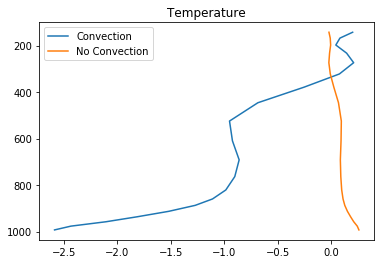

In [53]:
var_mean = dataset.mean()[6:26]
pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]

var_pos = pos.iloc[:,6:26]
var_neg = neg.iloc[:,6:26]

var_pos_anorm = var_pos.mean() - var_mean
var_neg_anorm = var_neg.mean() - var_mean

lev = np.loadtxt("lev.txt")
plt.plot(var_pos_anorm, lev, label="Convection")
plt.plot(var_neg_anorm, lev, label="No Convection")
plt.gca().invert_yaxis()
plt.title("Temperature")
plt.legend()

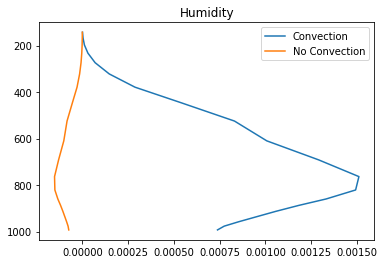

In [54]:
var_mean = dataset.mean()[26:46]
pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]

var_pos = pos.iloc[:,26:46]
var_neg = neg.iloc[:,26:46]

var_pos_anorm = var_pos.mean() - var_mean
var_neg_anorm = var_neg.mean() - var_mean

lev = np.loadtxt("lev.txt")
plt.plot(var_pos_anorm, lev, label="Convection")
plt.plot(var_neg_anorm, lev, label="No Convection")
plt.gca().invert_yaxis()
plt.title("Humidity")
plt.legend()

## other algorithms

In [10]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=10)

In [11]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
#classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7))

cv_results = []
for classifier in classifiers :
    print(classifier)
    cv_results.append(cross_val_score(classifier, trig_x_train, y = trig_y_train, scoring = "f1", cv = kfold, n_jobs=4))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best')
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=2)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decreas

/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=8, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


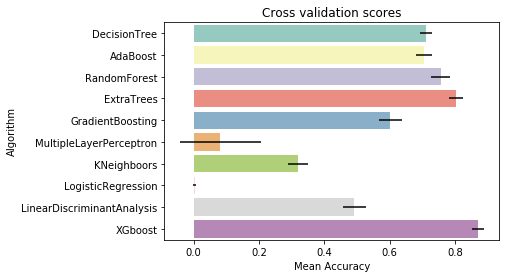

In [16]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGboost"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [17]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7, n_estimators=600)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="f1", n_jobs= 8, verbose = 1)

gsadaDTC.fit(trig_x_train,trig_y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   44.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 560 out of 560 | elapsed:  1.8min finished


In [18]:
print(ada_best)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=0.0001, n_estimators=600, random_state=7)


In [20]:
#ExtraTrees 
ExtC = ExtraTreesClassifier(n_estimators=600)


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsExtC.fit(trig_x_train,trig_y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_
print(ExtC_best)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed:  5.5min finished


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=10, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [21]:
# RFC Parameters tunning 
RFC = RandomForestClassifier(n_estimators=600)


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1", n_jobs= 8, verbose = 1)

gsRFC.fit(trig_x_train,trig_y_train)

RFC_best = gsRFC.best_estimator_

# Best score
print(gsRFC.best_score_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 14.6min
[Parallel(n_jobs=8)]: Done 270 out of 270 | elapsed: 44.0min finished


0.8367256987812449


In [22]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier(n_estimators=600)
gb_param_grid = {'loss' : ["deviance"],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="f1", n_jobs= 8, verbose = 1)

gsGBC.fit(trig_x_train,trig_y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/R1/zhangtao/soft/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 22.7min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 30.8min finished


0.8612824493199512

In [9]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [ ]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",trig_x_train,trig_y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",trig_x_train,trig_y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",trig_x_train,trig_y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",trig_x_train,trig_y_train,cv=kfold)

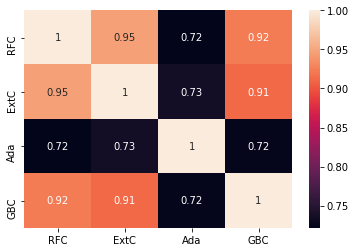

In [27]:
test_Survived_RFC = pd.Series(RFC_best.predict(trig_x_test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(trig_x_test), name="ExtC")
test_Survived_AdaC = pd.Series(ada_best.predict(trig_x_test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(trig_x_test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [28]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(trig_x_train, trig_y_train)
trig_y_prec = votingC.predict(trig_x_test)
print(f1_score(trig_y_test, trig_y_prec))

0.8771929824561404


## Test with Trmm and ERA-interim data [not used]

In [51]:
dataset_trmm = load_data.load_sgp1()
print(dataset_trmm.dtypes)

t2m       float64
d2m       float64
sp        float64
cape      float64
lcl       float64
clabel    float64
t_100     float64
t_125     float64
t_150     float64
t_175     float64
t_200     float64
t_225     float64
t_250     float64
t_300     float64
t_350     float64
t_400     float64
t_450     float64
t_500     float64
t_550     float64
t_600     float64
t_650     float64
t_700     float64
t_750     float64
t_775     float64
t_800     float64
t_825     float64
t_850     float64
t_875     float64
t_900     float64
t_925     float64
           ...   
w_175     float64
w_200     float64
w_225     float64
w_250     float64
w_300     float64
w_350     float64
w_400     float64
w_450     float64
w_500     float64
w_550     float64
w_600     float64
w_650     float64
w_700     float64
w_750     float64
w_775     float64
w_800     float64
w_825     float64
w_850     float64
w_875     float64
w_900     float64
w_925     float64
w_950     float64
w_975     float64
w_1000    float64
label     

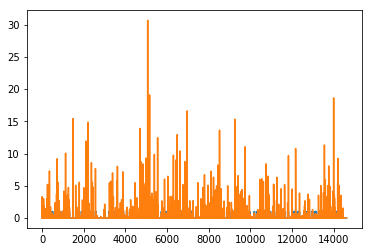

In [13]:
trig_x = dataset_trmm.iloc[:,0:114]
trig_y = dataset_trmm.iloc[:,114]
plt.plot(trig_y)
dataset_trmm['prect'].plot()

In [82]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7,scale_pos_weight=55.5)
f1_scores = cross_val_score(xgb, trig_x, trig_y, cv=cv, scoring="f1_macro")
print(f1_scores)

[0.66405593 0.67728584 0.62526149 0.66531989 0.66946717]


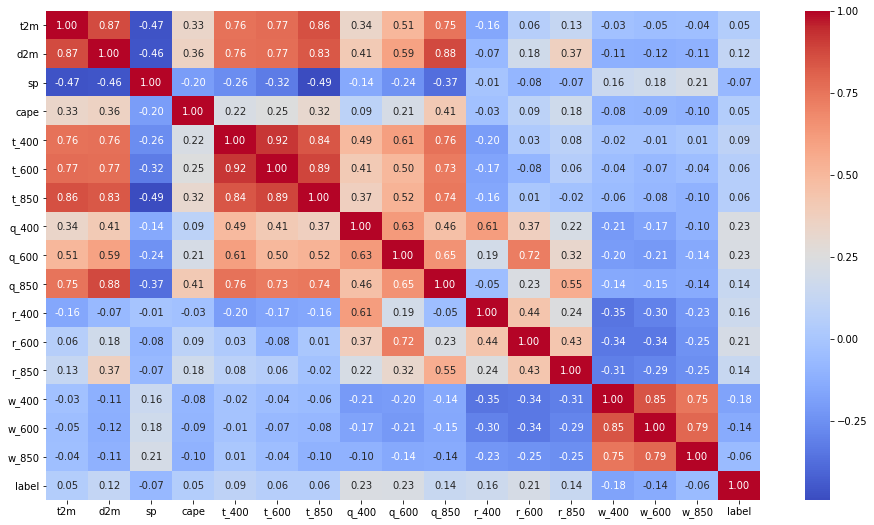

In [18]:
plt.figure(figsize=(16,9))
g = sns.heatmap(dataset_trmm[["t2m","d2m","sp","cape","t_400","t_600","t_850", "q_400","q_600", "q_850",
                         "r_400","r_600", "r_850",
                         "w_400","w_600", "w_850","label"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

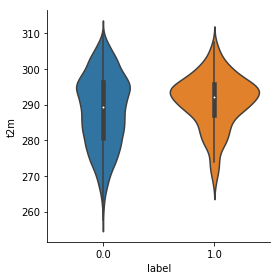

In [20]:
g = sns.factorplot(x="label", y = "t2m",data = dataset_trmm, kind="violin")

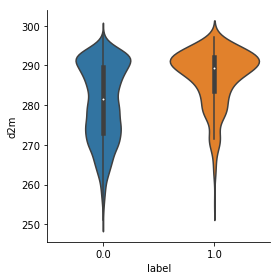

In [21]:
g = sns.factorplot(x="label", y = "d2m",data = dataset_trmm, kind="violin")

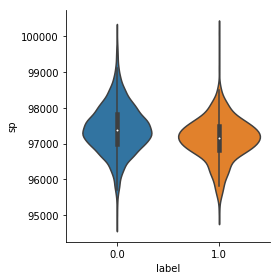

In [22]:
g = sns.factorplot(x="label", y = "sp",data = dataset_trmm, kind="violin")

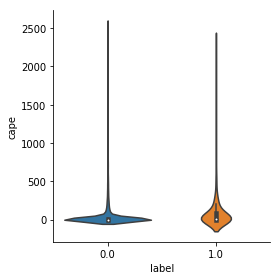

In [23]:
g = sns.factorplot(x="label", y = "cape",data = dataset_trmm, kind="violin")

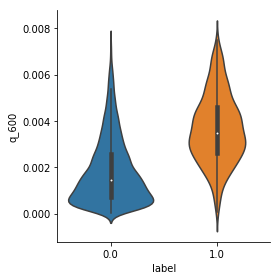

In [24]:
g = sns.factorplot(x="label", y = "q_600",data = dataset_trmm, kind="violin")

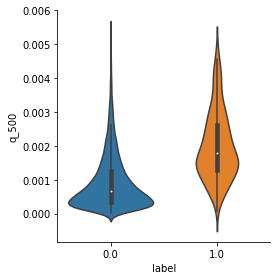

In [25]:
g = sns.factorplot(x="label", y = "q_500",data = dataset_trmm, kind="violin")

In [80]:
df = dataset_trmm.reset_index(drop=True)
df = df.sample(frac=0.3)
df = df.reset_index(drop=True)
ntime=df.shape[0]
plabel = np.zeros(ntime)

a=0
for i in range(ntime):
    if(df.loc[i,'q_600'] > 0.003):
        plabel[i] = 1
        a = a +1
    else:
        plabel[i] = 0

print(a)
print(f1_score(df.loc[:,'label'], plabel))


864
0.19444444444444448


(488, 120)
(14123, 120)


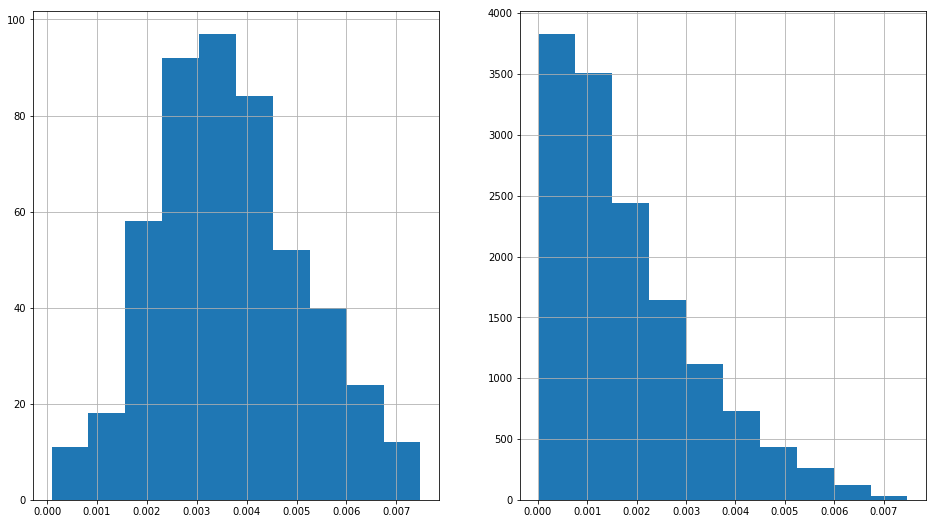

In [70]:

pos = df[df.label==1]
neg = df[df.label==0]

print(pos.shape)
print(neg.shape)

plt.figure(figsize=(16,9))
plt.subplot(121)
pos['q_600'].hist()
plt.subplot(122)
neg['q_600'].hist()

## Performance with dilute dcape

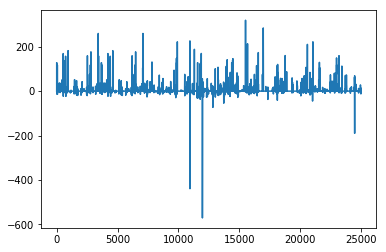

In [20]:
ddcape = np.loadtxt("/R0/wlin/Tao/CPS_trigger/data/sgp/sgp_dilute_dcape.txt")
dataset['cape'] = ddcape
dataset['cape'].plot()

In [36]:
trig_x = dataset.iloc[:,0:86]
trig_y = dataset.iloc[:,86]
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
xgb = XGBClassifier(n_estimators=600,silent=True, nthread=8, max_depth=7,scale_pos_weight=3.5)
f1_scores = cross_val_score(xgb, trig_x, trig_y, cv=cv, scoring="f1_macro")
print(f1_scores)

[0.91311363 0.90544706 0.90968324 0.92539378 0.91991816]


In [41]:
trig_x_train,trig_x_test,trig_y_train,trig_y_test= train_test_split(trig_x, trig_y, test_size=0.2, random_state=20)
ddcape = trig_x_test.loc[:,'cape'].tolist()
ntime = len(ddcape)
ddlabel = np.zeros(ntime)
for i in range(ntime):
    if ddcape[i] > 70: 
        ddlabel[i] = 1 
    else:
        ddlabel[i] = 0

tn, fp, fn, tp = confusion_matrix(trig_y_test, ddlabel).ravel()
f1 = f1_score(trig_y_test, ddlabel,average='macro')

a = tp
b = fp
c = fn
d = tn  
hss  = my_metrics.hss_score(a,b,c,d)
seds = my_metrics.seds_score(a,b,c,d)
ets  = my_metrics.ets_score(a,b,c,d)

print(tp,fp,fn,tn)
print(f1)
print(hss,seds,ets)

print(len(trig_x_train))
print(len(trig_x_test))
print(sum(trig_y_train))
print(sum(trig_y_test))

408 3544 42 1008
0.2726208803534663
0.028427683148589938 0.054915301388339666 0.014418787941792967
20006
5002
1833.0
450.0


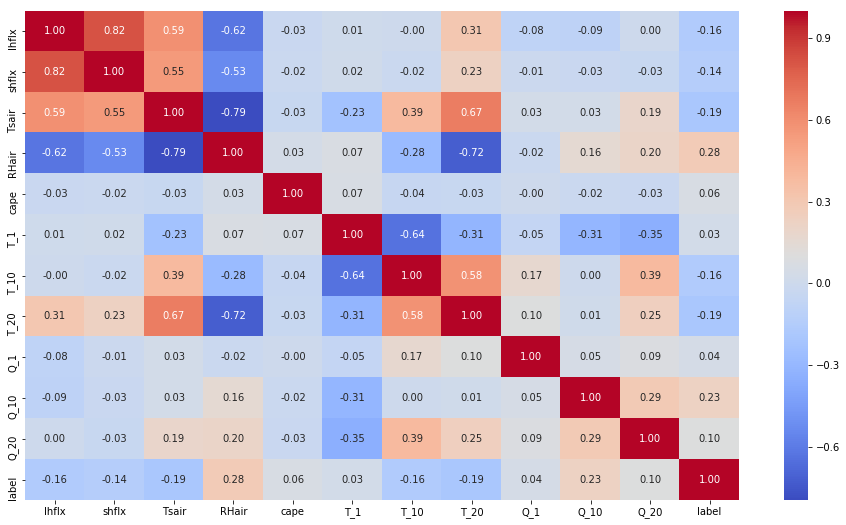

In [18]:
plt.figure(figsize=(16,9))
g = sns.heatmap(dataset[["lhflx","shflx","Tsair","RHair","cape","T_1","T_10","T_20", "Q_1","Q_10", "Q_20","label"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [25]:
tp = 114
fp = 201
fn = 336
tn = 4351

p = tp/(tp+fp)
r = tp/(tp+fn)
f1 = 2*p*r/(p+r)
print(f1)

a = tn
b = fn
c = fp
d = tp  

p1 = a/(a+c)
r1 = a/(a+b)
f11 = 2*p1*r1/(p1 + r1)
print(f11)

print((f1+f11)/2)


0.2980392156862745
0.941876826496374
0.6199580210913243


\begin{equation}\label{eq:}
P_a = \frac{TP}{TP+FP}\\
R_a = \frac{TP}{TP+FN} \\
P_b = \frac{TN}{TN+FN}\\
R_b = \frac{TN}{TN+FP} \\
f1_a = 2\frac{P_aR_a}{P_a + R_a} \\
f1_b = 2\frac{P_bR_b}{P_b + R_b} \\
f1\_macro = \frac{f1_a + f1_b}{2} 
\end{equation}


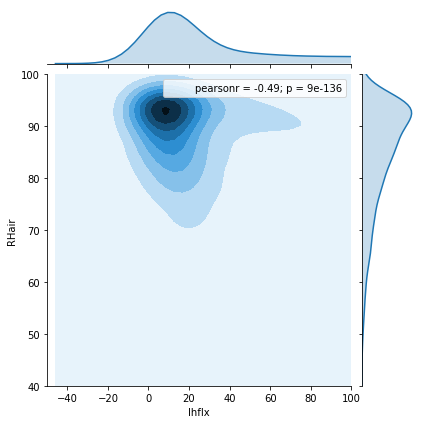

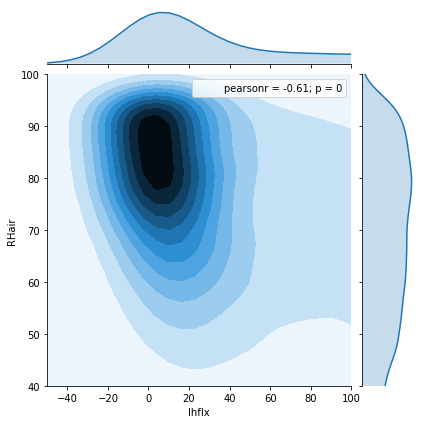

In [14]:
pos = dataset[dataset.label==1]
neg = dataset[dataset.label==0]


g = sns.jointplot(pos['lhflx'], pos['RHair'], kind="kde",xlim=[-50,100],ylim=[40,100])
g = sns.jointplot(neg['lhflx'],neg['RHair'], kind="kde",xlim=[-50,100],ylim=[40,100])

In [38]:
a = 0.658228
b = 1.109151

c = a + b - 1
print(c)

0.767379
